# 1. generate Tokens
* 数据重采样，避免样本不均衡，各采样10w个label
* 加入背景数据

In [1]:
DATA_PATH = '/content/drive/MyDrive/COMP3361/Assignment1/data/'
!head -n 10 /content/drive/MyDrive/COMP3361/Assignment1/data/valid.fo1
!pip install sklearn

homarus gammarus , known as the european lobster or common lobster , is a species **GW** <unk> lobster from the eastern atlantic ocean , mediterranean sea and parts **GW** the black sea . it is closely related to the american lobster , h. americanus . it may grow to a length **GW** 60 cm ( 24 **GW** ) and a mass **GW** 6 kilograms ( 13 lb ) , and bears a conspicuous pair **GW** claws . **GW** life , the lobsters are blue , only becoming " lobster red " **GW** cooking . mating occurs **GW** the summer , producing eggs which are carried by the females **GW** up to a year before hatching into <unk> larvae . homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the british isles .
homarus gammarus is a large <unk> , with a body length up to 60 centimetres ( 24 **GW** ) and weighing up to 5 – 6 kilograms ( 11 – 13 lb ) , although the lobsters caught **GW** lobster pots are usually 23 – 38 cm ( 9 – 15 **GW** ) long and weigh 0 @.@ 7 – 2 @.@ 2 kg

In [2]:
label_list = ['at', 'in', 'of', 'for', 'on', '**GW**']
label_dict = {'at':0, 'in':1, 'of':2, 'for':3, 'on':4, '**GW**':5, '<unk>':6}
n = 5
train_split = 13970

In [3]:
class DataFliter(object):
    def __init__(self, data_path, data_name):
        self.data = []
        ans = 0
        with open(data_path+data_name, 'r') as f:
            for line in f:
                self.data.append(line)
    def check_valid(self, s):
        return (' at ' in s) or (' in ' in s) or (' of ' in s) or (' for ' in s) or (' on ' in s) or ('**GW**' in s)
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

In [4]:
train_data = DataFliter(DATA_PATH, 'train.fo1')

In [5]:
len(train_data)

16170

# 2. Generate n-gram

In [6]:
from typing import List
from collections import Counter
class Ngram(object):
    def __init__(self, n):
        self.n = n
        self.stat = [None] * (n+1)
        self.stat_final = [None] * (n+1)
        self.ans = 0
    def add_sentence(self, str_list):
        padding = [" "]*(self.n+1)
        str_list =  padding + str_list + padding
        self.ans += len(str_list)-self.n-1
        for i in range(len(str_list)-self.n-1):
            for j in range(self.n+1):
                if self.stat[j] == None:
                    self.stat[j] = []
                self.stat[j].append(str(str_list[i:i+j+1]))

    def finish(self):
        for i in range(self.n+1):
            self.stat_final[i] = Counter(self.stat[i])

In [7]:
ngram=Ngram(5)
for i in train_data[0:train_split]:
    ngram.add_sentence(i.split(' '))
ngram.finish()

In [8]:
nngram = ngram

# 3. Random Forest Classification

## 1. Generate Datasets

In [9]:
def generate_Datasets(str_list):
    global Sum
    # str_list list[2*n+1]
    feature = []# will be list[2*n*5]
    for i in range(n):
        subStrList = str_list[n+1:n+i+2]
        a = [0]*5
        sum = 0
        for j in range(5):
            a[j] = ngram.stat_final[i+1].get(str([label_list[j]]+subStrList), 0)
            a[j] += 0.1
            sum += a[j]
        a = [i/sum for i in a]
        feature += a
    
    for i in range(n):
        subStrList = str_list[n-i-1:n]
        a = [0]*5
        sum = 0
        for j in range(5):
            a[j] = ngram.stat_final[i+1].get(str(subStrList+[label_list[j]]),  0)
            a[j] += 0.1
            sum += a[j]
        a = [i/sum for i in a]
        feature += a
    return feature, str_list[n]

In [10]:
padding = [' ']*n
features, labels = [], []
qwq=0
for i in train_data[train_split:]:
    sequence = padding + i.split(' ') + padding
    for j in range(len(sequence)):
        if sequence[j] in label_list:
            feature, label = generate_Datasets(sequence[j-n:j+n+1])
            features.append(feature)
            labels.append(label)

In [11]:
labels_num=[label_dict[i] for i in labels]

In [12]:
counted = sorted(Counter(labels_num).items())
Sum=0
for i in counted:
    Sum+=i[1]
print(counted, Sum)

[(0, 1012), (1, 5656), (2, 7822), (3, 1706), (4, 1578)] 17774


In [13]:
len(features)

17774

In [14]:
len(labels_num)

17774

In [15]:
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2000)
model.fit(features, labels_num)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 2. evaluate the train result

In [16]:
class DataFliter_subsentence(object):
    def __init__(self, data_path, data_name):
        self.data = []
        ans = 0
        with open(data_path+data_name, 'r') as f:
            for line in f:
                for sentence in line.split('.'):
                    for subsentence in sentence.split(';'):
                        for subsubsentence in subsentence.split(','):
                            if subsubsentence[len(subsubsentence)-1]=='\n':
                                subsubsentence=subsubsentence[0:len(subsubsentence)-1]
                            if subsubsentence!='':
                                self.data.append(subsubsentence)
    def check_valid(self, s):
        return ('at' in s) or (' in ' in s) or (' of ' in s) or (' for ' in s) or (' on ' in s) or (' **GW** ' in s)
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

In [17]:
valid_data = DataFliter(DATA_PATH, 'valid.fo1')
valid_data_label = DataFliter_subsentence(DATA_PATH, 'valid.fo2')

In [18]:
label_num = 0

padding = [' ']*n
valid_features, valid_labels = [], []
for i in valid_data:
    sequence = padding + i.split(' ') + padding
    for j in range(len(sequence)):
        if sequence[j] == "**GW**":
            feature, label = generate_Datasets(sequence[j-n:j+n+1])
            valid_features.append(feature)
            valid_labels.append(valid_data_label[label_num])
            label_num += 1

In [19]:
valid_labels_num=[label_dict[i] for i in valid_labels]

In [20]:
import numpy as np
pred = model.predict(np.array(valid_features))

from sklearn import metrics
print(metrics.classification_report(pred, np.ascontiguousarray(np.array(valid_labels_num)),digits=4))

              precision    recall  f1-score   support

           0     0.3373    0.7259    0.4606       467
           1     0.7899    0.7002    0.7424      5360
           2     0.8910    0.7637    0.8224      6914
           3     0.3797    0.6184    0.4705       781
           4     0.5310    0.8022    0.6390      1112

    accuracy                         0.7344     14634
   macro avg     0.5858    0.7221    0.6270     14634
weighted avg     0.7817    0.7344    0.7488     14634



Text(91.68, 0.5, 'predicted label')

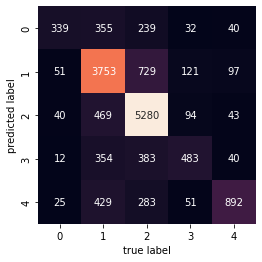

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn
mat = confusion_matrix(pred, np.ascontiguousarray(np.array(valid_labels_num)))
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# 4. Interface to predict

In [22]:
test_data = DataFliter(DATA_PATH, 'test.fo1')

In [23]:
padding = [' ']*n
test_features, test_labels = [], []
for i in test_data:
    sequence = padding + i.split(' ') + padding
    test_label = []
    for j in range(len(sequence)):
        if sequence[j] == "**GW**":
            feature, label = generate_Datasets(sequence[j-n:j+n+1])
            test_features.append(feature)
            test_label.append(label)
    test_labels.append(test_label)

In [24]:
import numpy as np
pred = model.predict(np.array(test_features))

In [26]:
import numpy as np
label_num = 0
pred = model.predict(np.array(test_features))
for i in test_labels:
    for j in range(len(i)):
        i[j] = label_list[pred[label_num]]
        label_num += 1

In [27]:
def processlist(x):
    str=""
    for i in x:
        str=str+i+","
    return str[:len(str)-1]+"\n"

In [28]:
with open(DATA_PATH+"test.fo3",'w') as f:
    for i in test_labels:
        f.write(processlist(i))